# IBM Applied Data Science Capstone

This is a final project of a professional certification course "IBM Data Science"

### Introduction


#### Business problem

The objective of this project is to determine an optimal location for opening a new coffee shop in Toronto. The location significantly affects on the profit of any company. Thus we could select the "right" location and get much more money. Using clustering approach allows us to solve this business problem.


#### Target audience

The target audience of this project is any person who cares about establishing new business connected with coffee shops.


### Data

To solve this problem we will need the following data:

- The neighborhood data, which describe names and postal codes of neighborhoods.
- Geolocation data with longitude and latitude of neighborhoods.
- Venues data (especially data related to existing coffee shops).

Data ccan be obtained from these sources:

- The neighborhoods data were taken from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)
- Neighborhoods Geolocation data were taken from the provided [.json file](https://cocl.us/Geospatial_data)
- Venues data were obtained using [Foursquare API](https://api.foursquare.com)


### Segmenting and Clustering Neighborhoods in Toronto: get data from Wikipedia

The process of an exploring neighborhoods in Toronto. The data has been parsed from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [3]:
#!conda install bs4

In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
r = requests.get(url)
soup = BeautifulSoup(r.text)
tables = soup.find_all('table')

In [4]:
table = tables[0]

df = pd.DataFrame(columns=range(0,3))
row_index = 0
for row in table.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    data = []
    for column in columns:
        data.append(column.get_text().rstrip())
    if(len(data) == 3):
        df.loc[row_index] = data
    row_index += 1
df.rename(columns={0: "PostalCode", 1: "Borough", 2: "Neighborhood"}, inplace=True)
df.head()

,PostalCode,Borough,Neighborhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
df.shape

(180, 3)

In [6]:
df.drop(df[df['Borough'] == 'Not assigned'].index, inplace=True)

In [7]:
df.shape

(103, 3)

### Segmenting and Clustering Neighborhoods in Toronto: add geospatial data

In [8]:
link_geo = 'https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(link_geo)
df_geo = df_geo.set_index('Postal Code')
df_geo.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [9]:
df = df.set_index('PostalCode')

In [10]:
df = df.merge(df_geo, left_index=True, right_index=True)
df.head()

,Borough,Neighborhood,Latitude,Longitude
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [15]:
df.shape

(103, 4)

### Segmenting and Clustering Neighborhoods in Toronto: draw map

In [16]:
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

In [13]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

In [14]:
toronto_data = df[df['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


In [15]:
map_toronto = folium.Map(location=[43.651, -79.347], zoom_start=10)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Work with Foursquare API: get the top 100 venues that are within a radius of 1000 meters

In [18]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20200805' 
LIMIT = 100

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'])

In [21]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site


In [22]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 271 uniques categories.


### Analyze neighborhoods

In [23]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop('Neighborhood', inplace=True, axis=1)
toronto_onehot.insert(0, 'Neighborhood', toronto_venues['Neighborhood'])
toronto_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Count frequencies of venues

In [24]:
grouped = toronto_onehot.groupby(["Neighborhood"]).mean().reset_index()
grouped.head(3)

,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Women's Store,Yoga Studio,Zoo
0,Berczy Park,0.00,0.0,0.010000,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.01,0.0,0.010000,0.0,0.0,0.0,0.0,0.01,0.0,...,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Business reply mail Processing Centre, South C...",0.00,0.0,0.021277,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### get top 5 venues in each neighborhood

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,Coffee Shop,Hotel,Restaurant,Café,Park
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bar,Restaurant,Bakery
2,"Business reply mail Processing Centre, South C...",Park,Coffee Shop,Pizza Place,Brewery,Sushi Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Café,Harbor / Marina,Coffee Shop,Dance Studio,Scenic Lookout
4,Central Bay Street,Coffee Shop,Clothing Store,Sushi Restaurant,Italian Restaurant,Park


In [76]:
cols = set(neighborhoods_venues_sorted['1st Most Common Venue'].unique())
cols |= set(neighborhoods_venues_sorted['2nd Most Common Venue'].unique())
cols |= set(neighborhoods_venues_sorted['3rd Most Common Venue'].unique())
cols |= set(neighborhoods_venues_sorted['4th Most Common Venue'].unique())
len(cols)

35

#### Select columns

We can select columns for the train dataset

In [77]:
train = grouped[list(cols)]
threshold = 0.01
train = train.drop(train.std()[train.std() < threshold].index.values, axis=1)
train.head()

,Café,Brewery,Grocery Store,Thai Restaurant,Pub,Mexican Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Convenience Store,Bakery,...,Fast Food Restaurant,Sushi Restaurant,Hotel,Theater,Gastropub,Italian Restaurant,Restaurant,Pharmacy,Gym / Fitness Center,Harbor / Marina
0,0.050000,0.00000,0.020000,0.010000,0.010000,0.00,0.01,0.00,0.0,0.020000,...,0.000000,0.000000,0.06,0.01,0.02,0.020000,0.06,0.0,0.01,0.000000
1,0.070000,0.01000,0.000000,0.000000,0.010000,0.01,0.02,0.02,0.0,0.040000,...,0.000000,0.000000,0.01,0.01,0.00,0.020000,0.05,0.0,0.01,0.000000
2,0.000000,0.06383,0.021277,0.021277,0.021277,0.00,0.00,0.00,0.0,0.021277,...,0.042553,0.042553,0.00,0.00,0.00,0.042553,0.00,0.0,0.00,0.021277
3,0.142857,0.00000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.0,0.000000,...,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.00,0.0,0.00,0.142857
4,0.030000,0.00000,0.000000,0.010000,0.000000,0.02,0.02,0.00,0.0,0.010000,...,0.010000,0.030000,0.02,0.02,0.02,0.030000,0.01,0.0,0.00,0.000000


### Clustering

In [52]:
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

#### Find an optimal k-value by elbow method

In [79]:
distortions = [] 
K = range(3, 10)

for k in K:
    model = KMeans(n_clusters=k).fit(train)
    model.fit(train)
    distortions.append(sum(np.min(cdist(train, model.cluster_centers_, 'euclidean'), axis=1)) / train.shape[0])

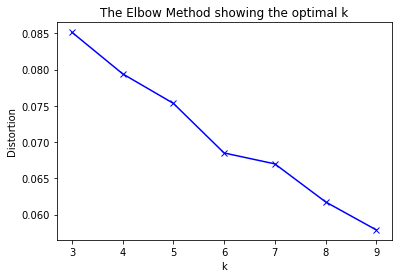

In [80]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### k-means with k=6

In [81]:
kclusters = 6
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(train)
kmeans.labels_[:10]

array([0, 1, 2, 5, 0, 1, 0, 0, 1, 0], dtype=int32)

In [96]:
neighborhoods_venues_sorted.drop('5th Most Common Venue', axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged = toronto_data
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
merged = merged.join(grouped[['Neighborhood', 'Coffee Shop']].set_index('Neighborhood'), on='Neighborhood')
merged.head(10) 

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,Coffee Shop
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Café,Pub,Diner,0.150000
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Park,0.120000
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Clothing Store,Gastropub,Italian Restaurant,0.100000
3,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Café,Coffee Shop,Restaurant,Clothing Store,0.070000
4,East Toronto,The Beaches,43.676357,-79.293031,1,Coffee Shop,Pub,Pizza Place,Japanese Restaurant,0.063291
5,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Hotel,Restaurant,Café,0.120000
6,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Coffee Shop,Clothing Store,Sushi Restaurant,Italian Restaurant,0.110000
7,Downtown Toronto,Christie,43.669542,-79.422564,1,Korean Restaurant,Café,Coffee Shop,Grocery Store,0.060000
8,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0,Coffee Shop,Café,Theater,Clothing Store,0.080000
9,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,Café,Coffee Shop,Park,Italian Restaurant,0.085714


#### Draw map with clusters

In [86]:
map_clusters = folium.Map(location=[43.651, -79.347], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Let's get deeper into the clusters

In [105]:
merged[merged['Cluster Labels'] == 0][['Neighborhood', 'Coffee Shop']].sort_values('Coffee Shop', ascending=False)

,Neighborhood,Coffee Shop
0,"Regent Park, Harbourfront",0.150000
34,Stn A PO Boxes,0.130000
1,"Queen's Park, Ontario Provincial Government",0.120000
5,Berczy Park,0.120000
20,Davisville North,0.120000
36,"First Canadian Place, Underground city",0.120000
37,Church and Wellesley,0.120000
6,Central Bay Street,0.110000
10,"Harbourfront East, Union Station, Toronto Islands",0.110000
13,"Toronto Dominion Centre, Design Exchange",0.110000


In [106]:
merged[merged['Cluster Labels'] == 1][['Neighborhood', 'Coffee Shop']].sort_values('Coffee Shop', ascending=False)

,Neighborhood,Coffee Shop
28,"Runnymede, Swansea",0.120000
26,Davisville,0.080000
12,"The Danforth West, Riverdale",0.070000
17,Studio District,0.070000
4,The Beaches,0.063291
7,Christie,0.060000
24,"The Annex, North Midtown, Yorkville",0.060000
30,"Kensington Market, Chinatown, Grange Park",0.060000
15,"India Bazaar, The Beaches West",0.051282
14,"Brockton, Parkdale Village, Exhibition Place",0.050000


In [107]:
merged[merged['Cluster Labels'] == 2][['Neighborhood', 'Coffee Shop']].sort_values('Coffee Shop', ascending=False)

,Neighborhood,Coffee Shop
31,"Summerhill West, Rathnelly, South Hill, Forest...",0.105263
33,Rosedale,0.095238
9,"Dufferin, Dovercourt Village",0.085714
38,"Business reply mail Processing Centre, South C...",0.085106
21,"Forest Hill North & West, Forest Hill Road Park",0.076923
23,"North Toronto West, Lawrence Park",0.071429
29,"Moore Park, Summerhill East",0.068966


In [108]:
merged[merged['Cluster Labels'] == 3][['Neighborhood', 'Coffee Shop']].sort_values('Coffee Shop', ascending=False)

,Neighborhood,Coffee Shop
19,Roselawn,0.095238


In [109]:
merged[merged['Cluster Labels'] == 4][['Neighborhood', 'Coffee Shop']].sort_values('Coffee Shop', ascending=False)

,Neighborhood,Coffee Shop
18,Lawrence Park,0.111111


In [110]:
merged[merged['Cluster Labels'] == 5][['Neighborhood', 'Coffee Shop']].sort_values('Coffee Shop', ascending=False)

,Neighborhood,Coffee Shop
32,"CN Tower, King and Spadina, Railway Lands, Har...",0.142857


#### Conclusion

We can see that clusters 0, 4, 5 have a very high number of coffee shops in most neighborhoods, otherwise, clusters 1, 2, 3 has a low number of coffee shops. It provides a great opportunity for establishing a new business.

Based on the map, most coffee shops are concentrated in the center of the city, meanwhile, the suburban area still has very few coffee shops. 

#### Discussion

This notebook provides a very simple way to visualize and analyze data, but the next steps can go deeper and analyze the relationship between cafes and other types of establishments. You can also use additional datasets, for example, with data on the cost of rent and the index of the popularity of the area.